# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import re
from keras.callbacks import ModelCheckpoint, LambdaCallback

In [6]:
import platform
print(platform.system())

Linux


In [7]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1) DATA PRE-PROCESSING

a) Load in kaggle data labels + image file paths

b) combine kaggle data labels and image file paths into one dataframe

c) load in the extra 486 image file paths

d) extract the speed and angle labels from the file path names

e) store that extra data in a pandas df and do the value normalisation

f) merge the kaggle and extra data dfs

g) EDA

h) convert the images to numerical RGB feature maps

i) split data into training-validation sets

j) data augmentation applied to training set

### 1a) load in kaggle data labels + image file paths

In [9]:
# labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # tylers file path
labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
# labels_file_path = '/home/ppytr13/machine-learning-in-science-ii-2025/training_norm.csv' # tyler hpc file path (mlis2 cluster)
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [10]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data' # OG data ben hpc file path (mlis2 cluster)
# image_folder_path = '/home/ppytr13/machine-learning-in-science-ii-2025//training_data/training_data'
# image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

Checking labels dataframe

In [11]:
labels_df.head()

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0


Checking image file paths dataframe - as you can see the file paths are ordered correctly (1.png, 2.png, 3.png, ...)

In [12]:
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/5.png


### 1b) Combine the kaggle labels and image file paths into one dataframe

In [13]:
kaggle_df = pd.merge(labels_df, imagefilepaths_df, on='image_id', how='inner')
kaggle_df['speed'] = kaggle_df['speed'].round(6) # to get rid of floating point errors

In [14]:
kaggle_df.tail()

,angle,speed,image_file_paths
image_id,,,
13794,0.6250,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13794.png
13795,0.4375,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13795.png
13796,0.5625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13796.png
13797,0.6250,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13797.png
13798,0.6875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13798.png


In [15]:
kaggle_df.loc[3139:3143]

,angle,speed,image_file_paths
image_id,,,
3139,0.750,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3139.png
3140,0.875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3140.png
3142,0.625,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3142.png
3143,0.625,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/3143.png


The above cell shows that:

 1) the image files and labels match (see image_id and the number at the end of the file path)

 2) the missing rows in labels_df (image_id: 3141, 3999, 4895, 8285, 10171) have been taken care of

### 1c) load in the extra 486 labels image file paths

In [16]:
extradata_folder_path = '/home/apyba3/petru_data'

extradata_file_paths = [
    os.path.join(extradata_folder_path, f)
    for f in os.listdir(extradata_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

### 1d) extract the speed and angle labels from the file path names

image file path name follows the pattern: `randomnumber_angle_speed`

In [17]:
# Regex pattern to extract angle and speed values
pattern = r'(\d+)_([\d]+)_([\d]+)\.png'

angle_value = []
speed_value = []

# Loop through file paths and extract angle and speed values
for file_path in extradata_file_paths:
    match = re.search(pattern, file_path)
    if match:
        # Extract random number, angle, and speed values
        random_number = match.group(1)
        angle_value.append(int(match.group(2)))
        speed_value.append(int(match.group(3)))

checking it has stored the labels correctly (check if the angle_value order matches that of the file path)

In [18]:
print(angle_value[:3])
print(extradata_file_paths[:3])

[95, 100, 80]
['/home/apyba3/petru_data/1712918428740_95_0.png', '/home/apyba3/petru_data/1712923220525_100_50.png', '/home/apyba3/petru_data/1712923068961_80_35.png']


### 1e) store that extra data in a pandas df and do the value normalisation

In [19]:
extradata_df = pd.DataFrame({
    'angle': angle_value,
    'speed': speed_value,
    'image_file_paths': extradata_file_paths
})

# conversions (see kaggle data section)
extradata_df.loc[extradata_df['speed'] > 0, 'speed'] = 1
extradata_df['speed'] = pd.to_numeric(extradata_df['speed'], errors='coerce').fillna(0).astype(int)

extradata_df['angle'] = (extradata_df['angle'] - 50)/80

extradata_df.index = pd.RangeIndex(start=13799, stop=13799 + len(extradata_df), step=1)
extradata_df.index.name = 'image_id'

extradata_df.head()

,angle,speed,image_file_paths
image_id,,,
13799,0.5625,0,/home/apyba3/petru_data/1712918428740_95_0.png
13800,0.6250,1,/home/apyba3/petru_data/1712923220525_100_50.png
13801,0.3750,1,/home/apyba3/petru_data/1712923068961_80_35.png
13802,0.6875,0,/home/apyba3/petru_data/1712921566265_105_0.png
13803,0.2500,1,/home/apyba3/petru_data/1712915924250_70_35.png


### 1f) merge the kaggle and extra data dfs

In [20]:
merged_df = pd.concat([kaggle_df, extradata_df])
merged_df.loc[13797:13800]

,angle,speed,image_file_paths
image_id,,,
13797,0.6250,0.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13797.png
13798,0.6875,1.0,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_data/training_data/13798.png
13799,0.5625,0.0,/home/apyba3/petru_data/1712918428740_95_0.png
13800,0.6250,1.0,/home/apyba3/petru_data/1712923220525_100_50.png


### 1g) EDA - speed column

In [21]:
merged_df.value_counts('speed')

speed
1.000000    10840
0.000000     3438
1.428571        1
Name: count, dtype: int64

note: imbalance datset

we want to remove the row containing the erroneous 1.428571 speed value

In [22]:
cleaned_df = merged_df[merged_df['speed'] != 1.428571]

In [23]:
cleaned_df.value_counts('speed')

speed
1.0    10840
0.0     3438
Name: count, dtype: int64

### 1h) convert images to numerical RGB feature maps

In [24]:
BATCH_SIZE = 32

In [25]:
def process_image(image_path, label, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resized_shape)
    image = image / 255.0  # Normalise pixel values to [0,1]
    return image, label

dataset = tf.data.Dataset.from_tensor_slices((cleaned_df["image_file_paths"], cleaned_df["speed"])) # Convert pd df into a tf ds

dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset.cache()
dataset = dataset.shuffle(len(cleaned_df))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

2025-04-30 22:28:07.898719: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


lets check and see if what we have done works

In [26]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

(32, 224, 224, 3) (32,)


### 1i) Splitting data into training and validation sets (test set is already provided in kaggle data)

In [27]:
# 80-20 split

dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [28]:
print(f"Train size: {train_size}, validation size: {dataset_size - train_size}")

Train size: 357, validation size: 90


### 1j) Data Augmentation applied to training set

- Random Brightness Adjustment
- Random Contrast Adjustment
- Random Hue Adjustment
- Random Saturation Adjustment
- Random Horizontal Flip



In [29]:
def augment_image(image, label):
  seed = (6, 9)
  image = tf.image.stateless_random_brightness(image, 0.2, seed)
  image = tf.image.stateless_random_contrast(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_hue(image, 0.2, seed)
  image = tf.image.stateless_random_saturation(image, 0.8, 1.2, seed)
  image = tf.image.stateless_random_flip_left_right(image, seed)
  return image, label

# Create a dataset of augmented images from the original train_dataset
augmented_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Concatenate the original and augmented datasets
train_dataset = train_dataset.concatenate(augmented_dataset)

# Shuffle the combined dataset
train_dataset = train_dataset.shuffle(buffer_size=len(cleaned_df))

In [30]:
angle_list = []

for image_batch, label_batch in train_dataset:
    angle_list.extend(label_batch.numpy())  # add all 32 values from the batch

angle_distribution = pd.Series(angle_list).value_counts().sort_index()
print(angle_distribution)


0.0     5536
1.0    17312
Name: count, dtype: int64


count how many images are in the training set - 22016 with no extradata and 80-20 split

In [31]:
total_images = 0
for image_batch, _ in train_dataset:
    total_images += image_batch.shape[0]  # Add the batch size

print(f"Total number of images in train_dataset: {total_images}")

Total number of images in train_dataset: 22848


checking to see if whats been done was successful or needs debugging

image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1


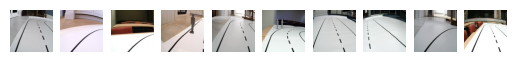

In [32]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in train_dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
plt.show()

# 2) CLASSIFICATION SPEED Model Building - MobNetV3Small Transfer Learning

### 2a) Set up model architecture

In [33]:
dropoutrate = 0.2
input_shape = (224,224,3)
num_classes = 1 # we're only predicting the prob of the positive class

In [34]:
mobnetv3small = tf.keras.applications.MobileNetV3Small(
    weights = 'imagenet',
    include_top = False,
    input_shape = input_shape
)

model = tf.keras.Sequential([
  mobnetv3small,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

mobnetv3small.trainable = False  # freeze mobnetv3small layers

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 256)               147712    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               3

compile the model

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

### 2c) train the model with the mobnetv3small layers frozen

In [ ]:
# Define checkpoint directory and create it if it doesn't exist
checkpoint_dir = '/home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define checkpoint filepath with keras extension (more compatible with TF 2.13)
checkpoint_filepath = os.path.join(checkpoint_dir, '50epochs_frozen_mobnetv3smallcheckpoint.keras')

# Create ModelCheckpoint with compatible parameters for TF 2.13
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
    # No save_weights_only parameter
)

# Define epoch callback
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
    on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
)

# Training with callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint, epoch_callback]
)


Starting Epoch 1...
Epoch 1/5


714/714 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.7587 - auc: 0.5304
Epoch 1: val_loss improved from inf to 0.54628, saving model to /home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/mobnetv3smallcheckpoint.h5
Completed Epoch 1, Loss: 0.5554, Val Loss: 0.5463
714/714 [==============================] - 73s 89ms/step - loss: 0.5554 - accuracy: 0.7587 - auc: 0.5304 - val_loss: 0.5463 - val_accuracy: 0.7547 - val_auc: 0.7527

Starting Epoch 2...
Epoch 2/5


/home/apyba3/anaconda3/envs/car_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


714/714 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.7592 - auc: 0.5995
Epoch 2: val_loss improved from 0.54628 to 0.54185, saving model to /home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/mobnetv3smallcheckpoint.h5
Completed Epoch 2, Loss: 0.5409, Val Loss: 0.5418
714/714 [==============================] - 70s 88ms/step - loss: 0.5409 - accuracy: 0.7592 - auc: 0.5995 - val_loss: 0.5418 - val_accuracy: 0.7607 - val_auc: 0.7913

Starting Epoch 3...
Epoch 3/5
714/714 [==============================] - ETA: 0s - loss: 0.5232 - accuracy: 0.7604 - auc: 0.6598
Epoch 3: val_loss improved from 0.54185 to 0.50551, saving model to /home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/mobnetv3smallcheckpoint.h5
Completed Epoch 3, Loss: 0.5232, Val Loss: 0.5055
714/714 [==============================] - 67s 86ms/step - loss: 0.5232 - accuracy: 0.7604 - auc: 0.6598 - val_loss: 0.5055 - val_accuracy: 0.7614 - val_auc: 0.8287

Starting Epoch 4...
Epoch 4/5
714/714 [===========

save the full model

In [ ]:
# Save the final model
model_path = '/home/apyba3/PICAR-autopilot-1/autopilot/models/BenTyler_MLiSards/50epochs_frozen_mobnetv3small_classification_model.keras'
model.save(model_path)
print(f"Final model saved to {model_path}")

Final model saved to /home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/models/mobnetv3small_classification_model.h5


save model weights

In [ ]:
model.save_weights('/home/apyba3/PICAR-autopilot-1/MobNetV3Small_Kaggle/weights/50epochs_frozentraining_classification_mobnetv3small.weights.keras')

: 

clear keras session

In [ ]:
tf.keras.backend.clear_session() #Clear keras session

### 2d) fine-tuning

rebuild model after clearing keras session

In [ ]:
mobnetv3small = tf.keras.applications.MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

model = tf.keras.Sequential([
  mobnetv3small,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

mobnetv3small.trainable = True  # UNfreeze mobnetv3small layers

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,697 (3.58 MB)

 Trainable params: 927,585 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

compile the model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # deliberately smaller learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

now load in the learned weights from training

In [ ]:
model.load_weights('/home/apyba3/PICAR-autopilot-1/MobNetV3Small_Kaggle/weights/50epochs_frozentraining_classification_mobnetv3small.weights.keras')

/home/apyba3/anaconda3/envs/mlis2cluster/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Initiate fine-tuning training

In [ ]:
# Define checkpoint directory and create it if it doesn't exist
checkpoint_dir = '/home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define checkpoint filepath with keras extension (more compatible with TF 2.13)
checkpoint_filepath = os.path.join(checkpoint_dir, 'finetuned_50epochs_mobnetv3smallcheckpoint.keras')

# Create ModelCheckpoint with compatible parameters for TF 2.13
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
    # No save_weights_only parameter
)

# Define epoch callback
epoch_callback = LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(f"\nStarting Epoch {epoch + 1}..."),
    on_epoch_end=lambda epoch, logs: print(f"Completed Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")
)

# Training with callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[model_checkpoint, epoch_callback]
)


Starting Epoch 1...
Epoch 1/50
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8811 - auc: 0.8638 - loss: 1.4939  
Epoch 1: val_loss improved from inf to 4.26729, saving model to /home/apyba3/MobNetV3Small/mobnetv3smallcheckpoint.keras
Completed Epoch 1, Loss: 0.6943, Val Loss: 4.2673
714/714 ━━━━━━━━━━━━━━━━━━━━ 330s 435ms/step - accuracy: 0.8811 - auc: 0.8639 - loss: 1.4928 - val_accuracy: 0.2455 - val_auc: 0.5288 - val_loss: 4.2673

Starting Epoch 2...
Epoch 2/50
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9601 - auc: 0.9798 - loss: 0.1693  
Epoch 2: val_loss improved from 4.26729 to 2.47814, saving model to /home/apyba3/MobNetV3Small/mobnetv3smallcheckpoint.keras
Completed Epoch 2, Loss: 0.1417, Val Loss: 2.4781
714/714 ━━━━━━━━━━━━━━━━━━━━ 315s 431ms/step - accuracy: 0.9601 - auc: 0.9798 - loss: 0.1692 - val_accuracy: 0.2459 - val_auc: 0.5861 - val_loss: 2.4781

Starting Epoch 3...
Epoch 3/50
714/714 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9696 - au

KeyboardInterrupt: 

save the model

In [ ]:
# Save the final model
model_path = '/home/apyba3/PICAR-autopilot-1/autopilot/models/BenTyler_MLiSards/finetuned_50epochs_mobnetv3small_classification_model.keras'
model.save(model_path)
print(f"Final model saved to {model_path}")

save the weights learned from fine tuning

In [ ]:
model.save_weights('/home/apyba3/PICAR-autopilot/MobNetV3Small_Kaggle/weights/fintuning_training_mobnetv3small_classification_weights.weights.keras')

# 3) CLASSIFICATION SPEED Test-Set Predictions

a) load in test data

b) convert test images to numerical RGB feature maps

c) generate predictions on the test set

d) correctly format the predictions into a pandas dataframe

e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

### 3a) load in test data

In [34]:
image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data'
# image_folder_path = '/home/ppyt13/machine-learning-in-science-ii-2025/test_data/test_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'
imagefilepaths_df.head()

,image_file_paths
image_id,
1,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/1.png
2,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/2.png
3,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/3.png
4,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/4.png
5,/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/test_data/test_data/5.png


### 3b) convert test images to numerical RGB feature maps

In [35]:
def process_image_no_label(image_path, resized_shape=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Use decode_png for PNG images
    image = tf.image.resize(image, resized_shape)  # Resize to uniform shape
    image = image / 255.0  # Normalize pixel values to [0,1]
    return image

test_dataset = tf.data.Dataset.from_tensor_slices((imagefilepaths_df["image_file_paths"]))

test_dataset = test_dataset.map(process_image_no_label, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### 3c) generate predictions on test set

In [36]:
predictions = model.predict(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step


### 3d) correctly format the predictions into a pandas dataframe

In [37]:
predictions_df = pd.DataFrame(predictions, columns=['speed'])

In [38]:
predictions_df.head()

,speed
0,1.370914e-25
1,1.000000e+00
2,9.999998e-01
3,1.000000e+00
4,9.998439e-01


In [39]:
predictions_df[predictions_df['speed'] > 0.5] = 1
predictions_df[predictions_df['speed'] < 0.5] = 0

predictions_df['speed'] = predictions_df['speed'].astype(int)

In [40]:
predictions_df.head()

,speed
0,0
1,1
2,1
3,1
4,1


In [41]:
predictions_df['speed'].value_counts()

speed
1    516
0    504
Name: count, dtype: int64

### 3e) save predictions to a file inside the hpc (to then later send from hpc to my laptop)

In [42]:
predictions_df.to_csv('/home/apyba3/mobnetv3small_speedclassification_withvalidation_withpetrudata.csv')